<a href="https://colab.research.google.com/github/Abudhagir/EVA8/blob/main/EVA8_AssignmentS7_AdvancedTrainingConcepts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA 8 - Assignment 8

## Submission by U.Syed Abudhagir (syedabudhagir@gmail.com)

## Goals:

You are going to follow the same structure for your Code from now on. So Create:

    1. models folder - this is where you'll add all of your future models. Copy resnet.py into this folder, this file should only have ResNet 18/34 models. Delete Bottleneck Class
    2. main.py - from Google Colab, now onwards, this is the file that you'll import (along with the model). Your main file shall be able to take these params or you should be able to pull functions from it and then perform operations, like (including but not limited to):
        training and test loops
        data split between test and train
        epochs
        batch size
        which optimizer to run
        do we run a scheduler?
    3. utils.py file (or a folder later on when it expands) - this is where you will add all of your utilities like:
        image transforms,
        gradcam,
        misclassification code,
        tensorboard related stuff - 
        advanced training policies, etc
        etc
    4. Name this main repos something, and don't call it Assignment 7. This is what you'll import for all the rest of the assignments. Add a proper readme describing all the files. 

1. Modularize code further by creating individual folders for models, utilities (training, testing, helper functions etc), containing generalized callable functions.
2. Upload modularized code to GitHub - to be used for all future assignments
3. Train ResNet18 model on CIFAR10 dataset for 20 epochs:
    * Use albumentations transforms/augmentations of RandomCrop, CutOut and Rotate
    * Use ReduceLROnPlateau as learning rate scheduler
    
4. Show gradcam outputs for 10/20 misclassified images

## Import Dependencies

In [9]:
## Install Dependencies
!pip install albumentations==0.4.6
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
## Clone Deep Learning Utils Repo
!git clone https://github.com/Abudhagir/syed_eva8.git

fatal: destination path 'syed_eva8' already exists and is not an empty directory.


In [12]:
from syed_eva8 import main


In [13]:
from syed_eva8.utils import data_handling, train, test, gradcam, helpers, augmentation


In [14]:
from syed_eva8.models import resnet


In [15]:
from pprint import pprint

## Import Config

In [16]:
config_file_path = "/content/syed_eva8/config/config.yaml"

config = helpers.load_config_variables(config_file_path)
pprint(config)

 Loading config ..
 Config succesfully loaded 
{'L2_penalty': 1e-05,
 'coarseDropoutProb': 0.5,
 'grayscaleProb': 0.15,
 'horizontalFlipProb': 0.2,
 'maxHeight': 16,
 'maxHoles': 1,
 'maxWidth': 16,
 'minHeight': 16,
 'minHoles': 1,
 'minWidth': 16,
 'momentum_val': 0.9,
 'padHeightWidth': 40,
 'randomCropProb': 1,
 'randomCropSize': 32,
 'rotateLimit': 5,
 'scaleLimit': 0.1,
 'sch_reduceLR_cooldown': 0,
 'sch_reduceLR_eps': 1e-08,
 'sch_reduceLR_factor': 0.1,
 'sch_reduceLR_min_lr': 0,
 'sch_reduceLR_mode': 'min',
 'sch_reduceLR_patience': 10,
 'sch_reduceLR_threshold': 0.0001,
 'sch_reduceLR_threshold_mode': 'abs',
 'shiftLimit': 0.1,
 'shiftScaleRotateProb': 0.25,
 'standard_lr': 0.01}


## Perform GPU Check; Create "Device"

In [17]:
device, cuda = helpers.gpu_check(seed_value = 1)
pprint(device)

CUDA unavailable
device(type='cpu')


## Download Dataset, Create Data Loaders

In [18]:
mean, std = data_handling.return_dataset_statistics()
trainloader, testloader = main.create_dataloaders(mean, std, cuda, config, augment_func = "albumentation_augmentation_S8")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


## Model Summary

In [19]:
from torchsummary import summary
model = resnet.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [20]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/CIFAR_1_Experiment')

In [22]:
import torchvision
import torchvision.transforms as transforms

In [31]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    
    
## Function to show sample data
def show_sample_data(trainloader, num_images = 16):
    
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    img_grid = torchvision.utils.make_grid(images)
    # show images
    imshow(torchvision.utils.make_grid(images[0:num_images]))
    # print labels
    print(' '.join('%5s' % cifar10_classes[labels[j]] for j in range(num_images)))

    writer.add_image('four_CIFAR_images', img_grid)

In [33]:
CUDA_VISIBLE_DEVICES=-1

In [35]:
tensorboard --logdir=runs

SyntaxError: ignored

In [34]:
tensorboard --logdir=runs

SyntaxError: ignored

In [32]:
writer.add_graph(model, images)
writer.close()

## Trigger Training

In [ ]:
train_acc, train_losses, test_acc, test_losses, lrs = main.trigger_training(model, device, trainloader, testloader, config, optimizer_name = "Adam", scheduler_name = "ReduceLROnPlateau", criterion_name = "CrossEntropyLoss", lambda_l1 = 0, epochs = 20)

EPOCH: 1


Loss=1.4999511241912842 Batch_id=390 LR=0.01000 Accuracy=33.22: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]



Test set: Average loss: 0.0120, Accuracy: 4497/10000 (44.97%)

EPOCH: 2


Loss=0.9853852391242981 Batch_id=390 LR=0.01000 Accuracy=51.06: 100%|██████████| 391/391 [00:46<00:00,  8.45it/s]



Test set: Average loss: 0.0093, Accuracy: 5847/10000 (58.47%)

EPOCH: 3


Loss=0.9823883175849915 Batch_id=390 LR=0.01000 Accuracy=61.92: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]



Test set: Average loss: 0.0085, Accuracy: 6176/10000 (61.76%)

EPOCH: 4


Loss=0.740376889705658 Batch_id=390 LR=0.01000 Accuracy=70.42: 100%|██████████| 391/391 [00:46<00:00,  8.46it/s]



Test set: Average loss: 0.0065, Accuracy: 7127/10000 (71.27%)

EPOCH: 5


Loss=0.6558500528335571 Batch_id=390 LR=0.01000 Accuracy=75.03: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]



Test set: Average loss: 0.0062, Accuracy: 7403/10000 (74.03%)

EPOCH: 6


Loss=0.5912505388259888 Batch_id=390 LR=0.01000 Accuracy=77.85: 100%|██████████| 391/391 [00:46<00:00,  8.44it/s]



Test set: Average loss: 0.0048, Accuracy: 7911/10000 (79.11%)

EPOCH: 7


Loss=0.45842161774635315 Batch_id=390 LR=0.01000 Accuracy=79.95: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]



Test set: Average loss: 0.0047, Accuracy: 7988/10000 (79.88%)

EPOCH: 8


Loss=0.4735172390937805 Batch_id=390 LR=0.01000 Accuracy=81.23: 100%|██████████| 391/391 [00:45<00:00,  8.52it/s]



Test set: Average loss: 0.0047, Accuracy: 7961/10000 (79.61%)

EPOCH: 9


Loss=0.45328935980796814 Batch_id=390 LR=0.01000 Accuracy=82.39: 100%|██████████| 391/391 [00:46<00:00,  8.48it/s]



Test set: Average loss: 0.0050, Accuracy: 7869/10000 (78.69%)

EPOCH: 10


Loss=0.42412853240966797 Batch_id=390 LR=0.01000 Accuracy=83.41: 100%|██████████| 391/391 [00:45<00:00,  8.52it/s]



Test set: Average loss: 0.0043, Accuracy: 8120/10000 (81.20%)

EPOCH: 11


Loss=0.5910761952400208 Batch_id=390 LR=0.01000 Accuracy=84.01: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]



Test set: Average loss: 0.0047, Accuracy: 8077/10000 (80.77%)

EPOCH: 12


Loss=0.35608142614364624 Batch_id=390 LR=0.01000 Accuracy=84.66: 100%|██████████| 391/391 [00:45<00:00,  8.60it/s]



Test set: Average loss: 0.0042, Accuracy: 8202/10000 (82.02%)

EPOCH: 13


Loss=0.4100375771522522 Batch_id=390 LR=0.01000 Accuracy=85.23: 100%|██████████| 391/391 [00:45<00:00,  8.57it/s]



Test set: Average loss: 0.0039, Accuracy: 8353/10000 (83.53%)

EPOCH: 14


Loss=0.49094828963279724 Batch_id=390 LR=0.01000 Accuracy=85.82: 100%|██████████| 391/391 [00:45<00:00,  8.54it/s]



Test set: Average loss: 0.0038, Accuracy: 8402/10000 (84.02%)

EPOCH: 15


Loss=0.3284186124801636 Batch_id=390 LR=0.01000 Accuracy=86.15: 100%|██████████| 391/391 [00:45<00:00,  8.60it/s]



Test set: Average loss: 0.0039, Accuracy: 8370/10000 (83.70%)

EPOCH: 16


Loss=0.44286054372787476 Batch_id=390 LR=0.01000 Accuracy=86.89: 100%|██████████| 391/391 [00:45<00:00,  8.62it/s]



Test set: Average loss: 0.0042, Accuracy: 8292/10000 (82.92%)

EPOCH: 17


Loss=0.465336412191391 Batch_id=390 LR=0.01000 Accuracy=87.10: 100%|██████████| 391/391 [00:45<00:00,  8.60it/s]



Test set: Average loss: 0.0037, Accuracy: 8462/10000 (84.62%)

EPOCH: 18


Loss=0.4775037169456482 Batch_id=390 LR=0.01000 Accuracy=87.12: 100%|██████████| 391/391 [00:45<00:00,  8.63it/s]



Test set: Average loss: 0.0036, Accuracy: 8515/10000 (85.15%)

EPOCH: 19


Loss=0.3650830090045929 Batch_id=390 LR=0.01000 Accuracy=87.45: 100%|██████████| 391/391 [00:45<00:00,  8.65it/s]



Test set: Average loss: 0.0034, Accuracy: 8534/10000 (85.34%)

EPOCH: 20


Loss=0.3687034249305725 Batch_id=390 LR=0.01000 Accuracy=87.77: 100%|██████████| 391/391 [00:45<00:00,  8.67it/s]



Test set: Average loss: 0.0038, Accuracy: 8453/10000 (84.53%)



## Plot Metrics

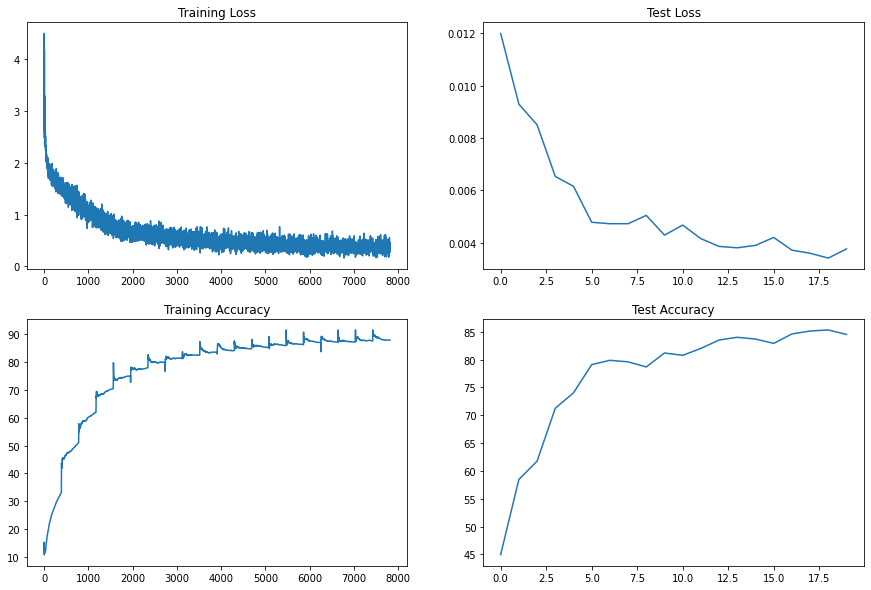

In [ ]:
helpers.plot_metrics(train_acc, train_losses, test_acc, test_losses)

## Misclassified Images

Total wrong predictions are 1547


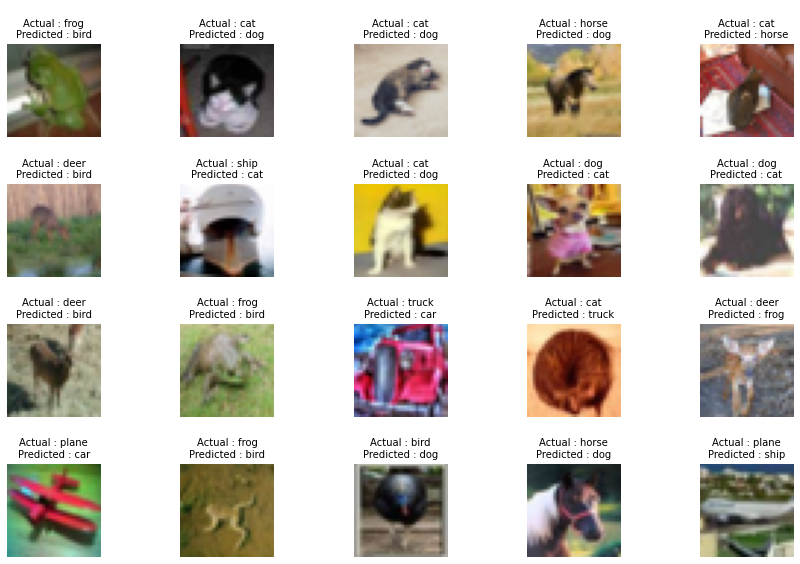

In [ ]:
misclassified_images = helpers.wrong_predictions(model, testloader, device)
helpers.plot_misclassified(misclassified_images, mean, std, 20)

## Gradcam

Generating Grad-CAM @layer4


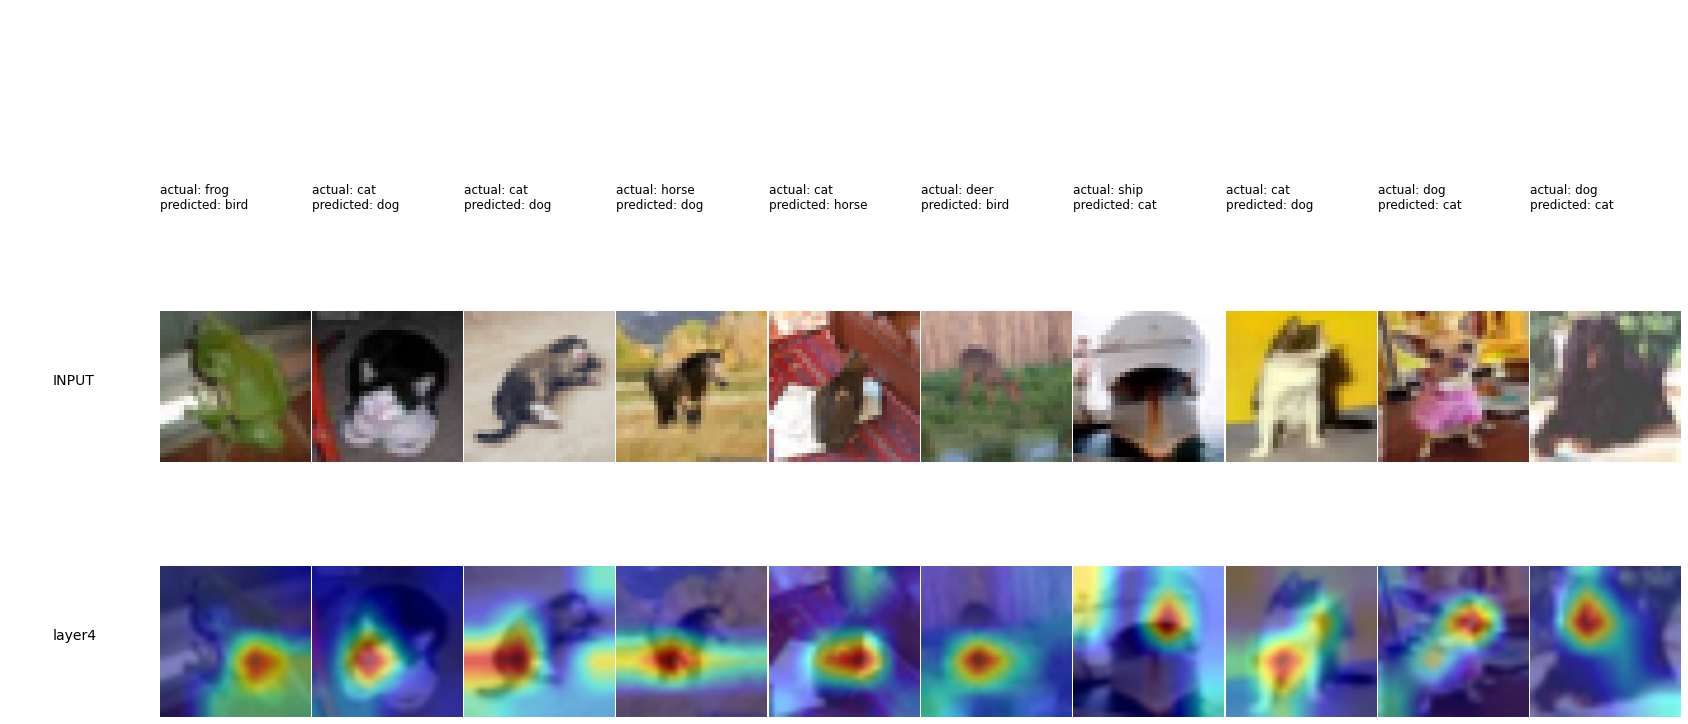

In [ ]:
target_layers = ["layer4"]
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
gradcam_output, probs, predicted_classes = gradcam.generate_gradcam(misclassified_images[:10], model, target_layers, device)
gradcam.plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[:10], mean, std)

Generating Grad-CAM @layer4


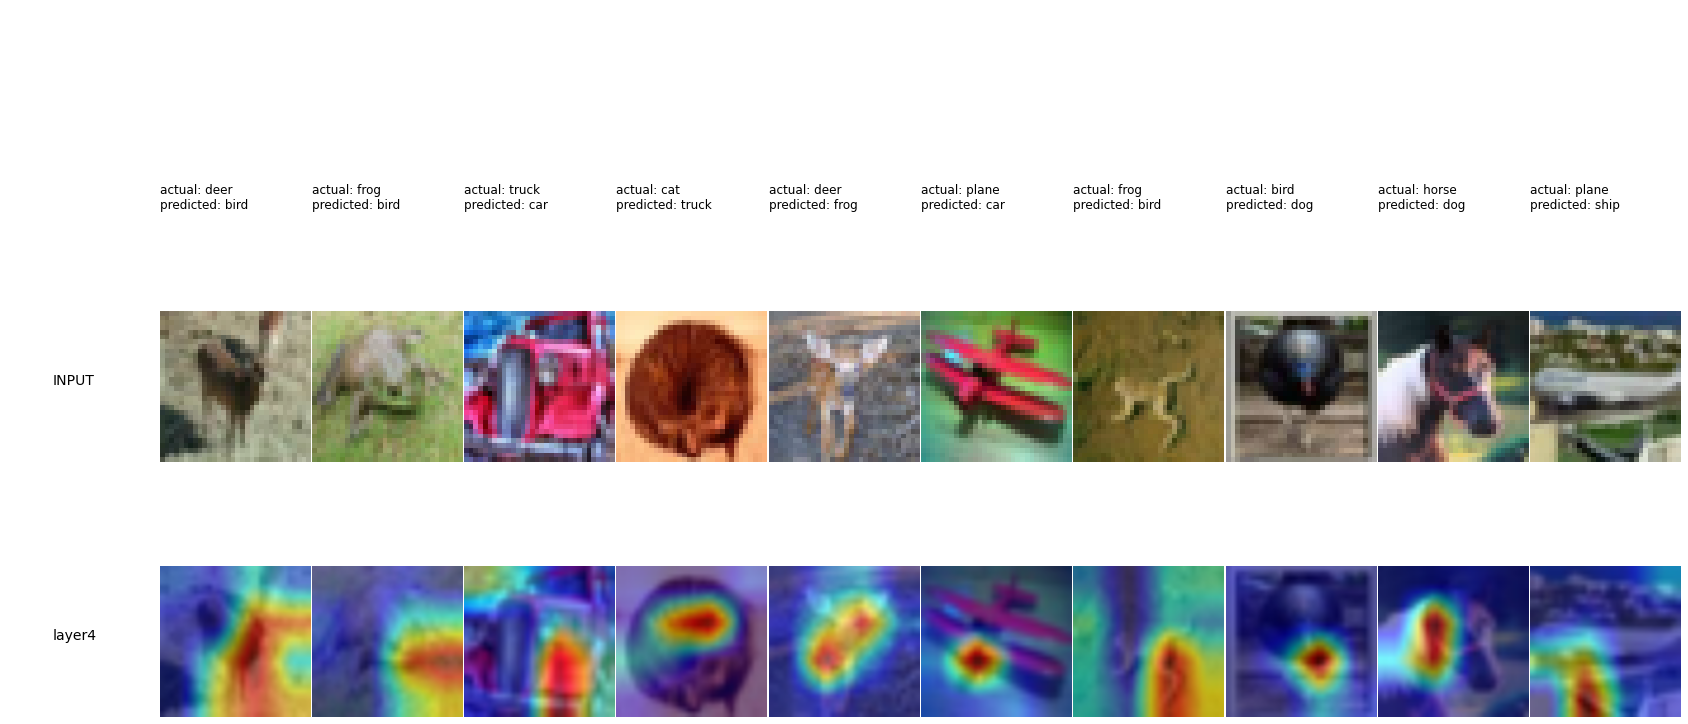

In [ ]:
target_layers = ["layer4"]
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
gradcam_output, probs, predicted_classes = gradcam.generate_gradcam(misclassified_images[10:20], model, target_layers, device)
gradcam.plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[10:20], mean, std)

In [36]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/CIFAR_1_Experiment')

In [37]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    
    
## Function to show sample data
def show_sample_data(trainloader, num_images = 16):
    
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    img_grid = torchvision.utils.make_grid(images)
    # show images
    imshow(torchvision.utils.make_grid(images[0:num_images]))
    # print labels
    print(' '.join('%5s' % cifar10_classes[labels[j]] for j in range(num_images)))

    writer.add_image('four_CIFAR_images', img_grid)

In [40]:
tensorboard --logdir=runs/CIFAR_1_Experiment

SyntaxError: ignored

In [39]:
writer.add_graph(model, images)
writer.close()